
TRAIN Dataset:
Number of samples: 100000
Points shape: (100000, 5, 3)
Volumes shape: (100000,)
Volume range: [0.000075, 0.278231]

TEST Dataset:
Number of samples: 5000
Points shape: (5000, 5, 3)
Volumes shape: (5000,)
Volume range: [0.000733, 0.199115]

VAL Dataset:
Number of samples: 5000
Points shape: (5000, 5, 3)
Volumes shape: (5000,)
Volume range: [0.000080, 0.184255]

GENERALIZATION Dataset:
Number of samples: 5000
Points shape: (5000, 10, 3)
Volumes shape: (5000,)
Volume range: [0.019739, 0.401425]


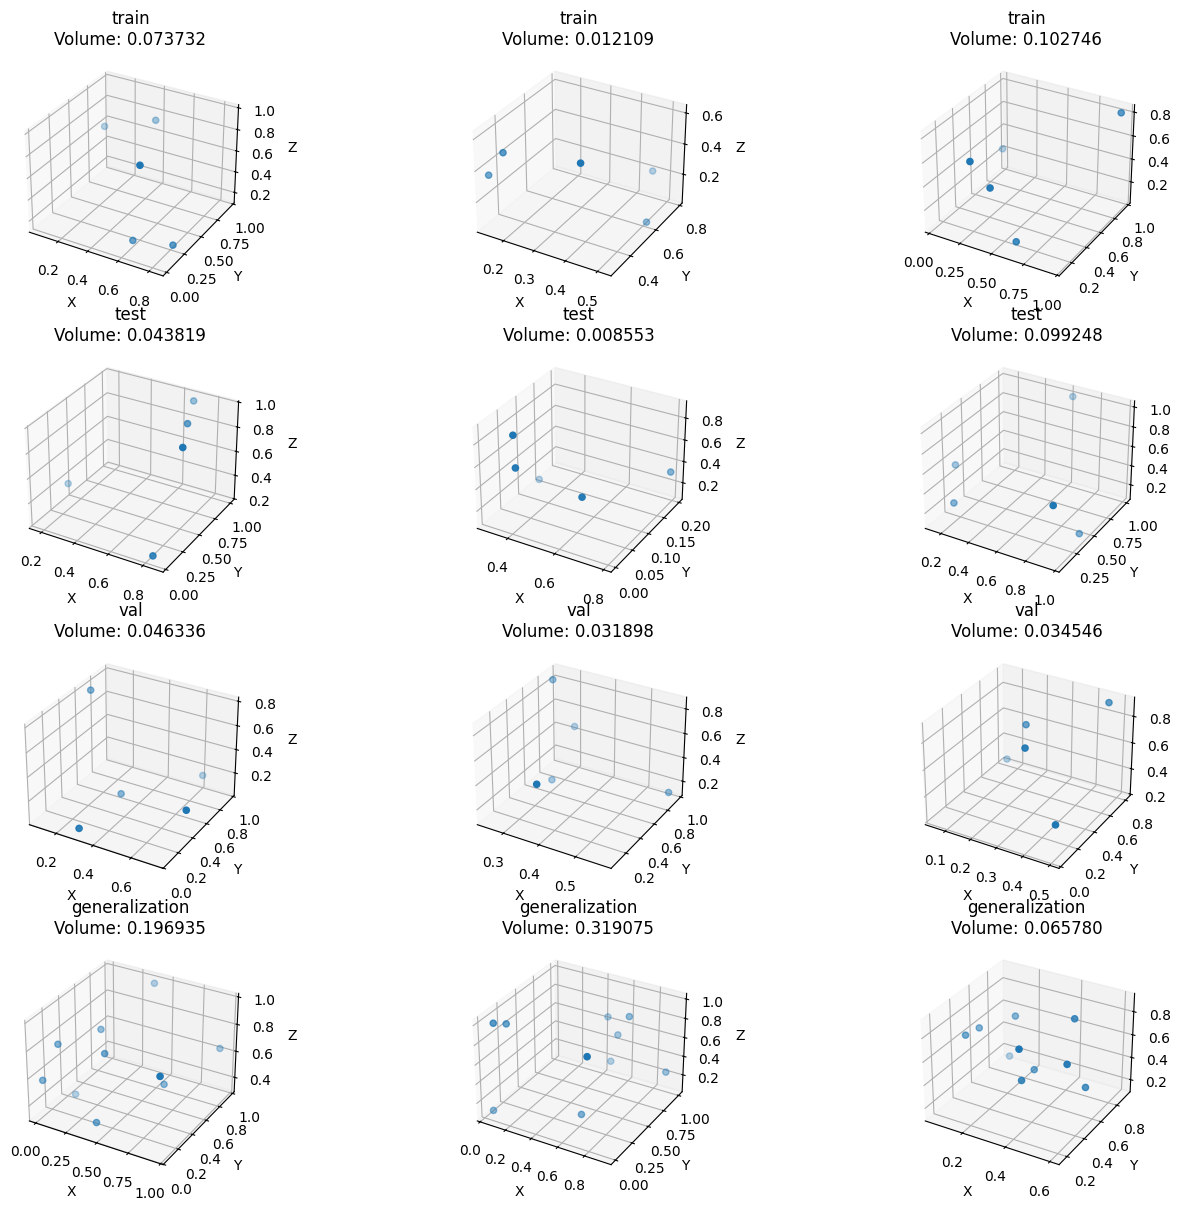

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

# Set the data directory
data_dir = Path("/storage_bizon/sabrant_rocket_2tb/ajay/repositories/ajay_code/geometric-algebra-transformer/tmp/gatr-experiments/data/volume")

# Function to plot points and convex hull
def plot_points(points, ax, title):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Load datasets
datasets = {}
for name in ['train', 'test', 'val', 'generalization']:
    data = np.load(data_dir / f"{name}.npz")
    datasets[name] = {
        'points': data['points'],
        'volumes': data['volumes']
    }
    print(f"\n{name.upper()} Dataset:")
    print(f"Number of samples: {len(data['points'])}")
    print(f"Points shape: {data['points'].shape}")
    print(f"Volumes shape: {data['volumes'].shape}")
    print(f"Volume range: [{data['volumes'].min():.6f}, {data['volumes'].max():.6f}]")

# Visualize first few examples from each dataset
fig = plt.figure(figsize=(15, 12))

for i, (name, data) in enumerate(datasets.items()):
    for j in range(3):  # Plot first 3 examples
        ax = fig.add_subplot(4, 3, i*3 + j + 1, projection='3d')
        points = data['points'][j]
        volume = data['volumes'][j]
        plot_points(points, ax, f"{name}\nVolume: {volume:.6f}")

plt.tight_layout()
plt.show()

In [3]:
# Print first 5 elements of the train dataset
print("\nFirst 5 elements of TRAIN dataset:")
for i in range(5):
    print(f"\nSample {i+1}:")
    print(f"Points:\n{datasets['train']['points'][i]}")
    print(f"Volume: {datasets['train']['volumes'][i]:.6f}")



First 5 elements of TRAIN dataset:

Sample 1:
Points:
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]]
Volume: 0.073732

Sample 2:
Points:
[[0.18340451 0.30424224 0.52475643]
 [0.43194502 0.29122914 0.61185289]
 [0.13949386 0.29214465 0.36636184]
 [0.45606998 0.78517596 0.19967378]
 [0.51423444 0.59241457 0.04645041]]
Volume: 0.012109

Sample 3:
Points:
[[0.60754485 0.17052412 0.06505159]
 [0.94888554 0.96563203 0.80839735]
 [0.30461377 0.09767211 0.68423303]
 [0.44015249 0.12203823 0.49517691]
 [0.03438852 0.9093204  0.25877998]]
Volume: 0.102746

Sample 4:
Points:
[[0.66252228 0.31171108 0.52006802]
 [0.54671028 0.18485446 0.96958463]
 [0.77513282 0.93949894 0.89482735]
 [0.59789998 0.92187424 0.0884925 ]
 [0.19598286 0.04522729 0.32533033]]
Volume: 0.057577

Sample 5:
Points:
[[0.38867729 0.27134903 0.82873751]
 [0.35675333 0.28093451 0.54269608]
 [0.1